# 2nd order Trotterization for Imaginary Time Evolution

So far, the code has been using a first order Trotterization for implementing the ITE:

$$ 
\begin{aligned}
e^{-\beta H} &= e^{-\beta (h[1]+h[2]+\cdots+h[k])} \\
&\approx \left(e^{-d\beta h[1]}e^{-d\beta h[2]} \cdots e^{-d\beta h[k]}\right)^N,\quad (d\beta = \frac{\beta}{N})
\end{aligned}
$$

In fact, this same trotter approximation is what we use to propagate the local terms via A
$$ 
\begin{aligned}
e^{-d\beta h[m]} &= e^{-d\beta \sum_I a_I \sigma_I} \\
&\approx \prod_I e^{-d\beta a_I \sigma_I} \\
&= \prod_I R_{\sigma_I}(-2 a_I)
\end{aligned}
$$

However, for a better convergence, a second order Trotterization should be used for the time evolution:
$$ 
\begin{aligned}
e^{-\beta H} &= e^{-\beta (h[1]+h[2]+\cdots+h[k])} \\
&\approx \left(e^{-\frac{d\beta}{2} h[1]}\cdots e^{-\frac{d\beta}{2} h[k]} e^{-\frac{d\beta}{2} h[k]} \cdots e^{-\frac{d\beta}{2} h[1]} \right)^N \\
&= \left(e^{-\frac{d\beta}{2} h[1]}\cdots e^{-\frac{d\beta}{2} h[k-1]} e^{-d\beta h[k]} e^{-\frac{d\beta}{2} h[k-1]} \cdots e^{-\frac{d\beta}{2} h[1]} \right)^N
\end{aligned}
$$

## Updates to the code
* `propagate` does not need to change as each local evolution is done via a 1st order Trotterization.
* `update_alist` will need a parameter to put the appropriate scaling constant in calculating the norm `c`: for the $e^{-d\beta/2 h}$ terms, `c -= 1*db*sigma_expectation[]`, and for the $e^{-d\beta h}$ terms, `c-= 2*db*sigma_expectation[]`.
* `qite_step` needs to run through `hm_list` forwards and backwards with appropriate scale factor sent to `update_alist` to properly implement the second order Trotterization.

In [1]:
import numpy as np
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

from helper import *
from ideal_qite import pauli_expectation, ideal_energy, ideal_tomography

In [24]:
def update_alist_2nd_ord(sigma_expectation, alist, db, delta, hm, scale, odd_y_flag):
    # number of qubits that the term acts on
    nactive = len(hm[2])
    # number of pauli terms present in hm
    nterms = len(hm[0])
    
    if odd_y_flag:
        odd_ys = odd_y_pauli_strings(nactive)
        nops = len(odd_ys)

        # Step 1: Obtain S matrix:
        # S[I,J] = <psi| sigma_I sigma_J |psi>
        S = np.zeros([nops,nops],dtype=complex)
        for i in range(nops):
            for j in range(nops):
                p,c_ = pauli_string_prod(odd_ys[i], odd_ys[j], nactive)
                S[i,j] = sigma_expectation[p] * c_

        # Step 2: Obtain b vector
        b = np.zeros(nops, dtype=complex)
        c = 1

        for i in range(nterms):
            c -= scale*db*sigma_expectation[hm[0][i]]
        c = np.sqrt(c)

        for k in range(nops):
            # This part not needed since it will always be real
            # b[k] += (1/c - 1) * sigma_expectation[odd_ys[k]] / db
            for j in range(nterms):
                p,c_ = pauli_string_prod(odd_ys[k], hm[0][j], nactive)
                b[k] -= hm[1][j] * c_ * sigma_expectation[p] / c
        b = -2*np.imag(b)
    else:
        nops = 4**nactive

        # Step 1: Obtain S matrix:
        # S[I,J] = <psi| sigma_I sigma_J |psi>

        S = np.zeros([nops,nops],dtype=complex)
        for i in range(nops):
            for j in range(nops):
                p,c_ = pauli_string_prod(i,j,nactive)
                S[i,j] = sigma_expectation[p]*c_

        # Step 2: Obtain b vector
        b = np.zeros(nops,dtype=complex)
        c = 1

        for i in range(nterms):
            c -= scale* db* hm[1][i] * sigma_expectation[hm[0][i]]
        c = np.sqrt(c)

        for i in range(nops):
            # This part not needed since it will always be real
            # b[i] += ( 1/c - 1 ) * sigma_expectation[i] / db
            for j in range(nterms):
                p,c_ = pauli_string_prod(i,hm[0][j],nactive)
                b[i] -= hm[1][j] * c_ * sigma_expectation[p] / c
        b = -2*np.imag(b)

    # Step 3: Add regularizer to make sure the system can be solved
    dalpha = np.eye(nops)*delta

    # Step 4: Solve the system
    x = np.linalg.lstsq(2*np.real(S) + dalpha, -b, rcond=-1)[0]

    # Multiply by -2*db so that the appropriate rotation is applied since the rotation about sigma gates are exp(-theta/2 sigma) but we want exp(theta sigma)
    a_coefficients = -2.0*db*x
    # Append to the a coefficients
    alist.append([a_coefficients, hm[2]])

    return c

In [25]:
def ideal_qite_step_2nd_ord(alist, db, delta, nbits, hm_list, init_sv, odd_y_flag):
    nterms = len(hm_list)
    for m in range(nterms-1):
        hm = hm_list[m]
        sigma_expectation, psi = ideal_tomography(hm, alist, hm[2], nbits, init_sv, odd_y_flag)
        update_alist_2nd_ord(sigma_expectation, alist, db, delta, hm, 1.0, odd_y_flag)
    
    hm = hm_list[-1]
    sigma_expectation,psi = ideal_tomography(hm, alist, hm[2], nbits, init_sv, odd_y_flag)
    update_alist_2nd_ord(sigma_expectation, alist, db, delta, hm, 2.0, odd_y_flag)
    
    for m in range(nterms-1,-1,-1):
        hm = hm_list[m]
        sigma_expectation, psi = ideal_tomography(hm, alist, hm[2], nbits, init_sv, odd_y_flag)
        update_alist_2nd_ord(sigma_expectation, alist, db, delta, hm, 1.0, odd_y_flag)
    
    return alist, psi

In [26]:
import time
from y_qite import y_log_qite_run
from qite import log_qite_run
def ideal_qite_2nd_ord(db,delta,N,nbits,hm_list,init_sv,details=False,log=False,log_file='ideal-qite'):
    odd_y_flag = is_real_hamiltonian(hm_list)
    E = np.zeros(N+1,dtype=complex)
    times = np.zeros(N+1,dtype=float)
    
    states = []
    if init_sv == None:
        states.append(Statevector.from_label('0'*nbits))
    else:
        states.append(init_sv)
    
    alist = []
    
    E[0] = ideal_energy(alist, nbits, hm_list, states[0], odd_y_flag)
    
    start = 0
    end = 0
    if details:
        print('Starting QITE Loop')
    
    for i in range(1,N+1):
        if details:
            print('i={}'.format(i), end=' ', flush=True)
            start = time.time()
        
        alist,psi = ideal_qite_step_2nd_ord(alist, db, delta, nbits, hm_list, states[0], odd_y_flag)
        E[i] = ideal_energy(alist, nbits, hm_list, states[0], odd_y_flag)
        states.append(psi)
        
        if details:
            end = time.time()
            duration = end-start
            times[i] = duration
            print('Execution time: {:.2f} seconds'.format(duration))
    
    if log:
        if odd_y_flag:
            y_log_qite_run(db,delta,N,nbits,hm_list,alist,log_file)
        else:
            log_qite_run(db,delta,N,nbits,hm_list,alist,log_file)
    
    return E,times,states

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

from os import path, makedirs

# QITE Parameters
db = 0.1       # Size of imaginary time step
N = 30          # Number of imaginary time steps
shots = 1000    # Number of measurements taken for each circuit
delta = 0.1     # Regularizer value

# Hamiltonian Description
nbits = 2       # Number of qubits in the full system

hm_list = []
hm = [ [3+1*4], [np.sqrt(0.5)], [0,1] ]
hm_list.append(hm)
hm = [ [1,3], [0.5, 0.5], [1]]
hm_list.append(hm)

h_name = 'Test'
# For this example, the Hamiltonian is of the form: 1/sqrt(2) (Z_0 X_1) + 1/sqrt(2) (I_0 H_1)

log_path = './qite_logs/ideal_qite_2nd_ord/{}/db={:0.1f}/N={}/'.format(h_name,db,N)
fig_path = './figs/ideal_qite_2nd_ord/{}/db={:0.1f}/N={}/'.format(h_name,db,N)

if not(path.exists(log_path)):
    makedirs(log_path)
if not(path.exists(fig_path)):
    makedirs(fig_path)

# Get the spectrum of H
w,v = get_spectrum(hm_list,nbits)
w = np.real(w)
w_sort_i = sorted(range(len(w)), key=lambda k: w[k])

Iteration: p0=0.00,p1=1.00
Starting QITE Loop
i=1 Execution time: 0.06 seconds
i=2 Execution time: 0.09 seconds
i=3 Execution time: 0.14 seconds
i=4 Execution time: 0.18 seconds
i=5 Execution time: 0.37 seconds
i=6 Execution time: 0.52 seconds
i=7 Execution time: 0.58 seconds
i=8 Execution time: 1.12 seconds
i=9 Execution time: 0.85 seconds
i=10 Execution time: 0.99 seconds
i=11 Execution time: 1.10 seconds
i=12 Execution time: 1.25 seconds
i=13 Execution time: 1.23 seconds
i=14 Execution time: 1.11 seconds
i=15 Execution time: 1.02 seconds
i=16 Execution time: 1.37 seconds
i=17 Execution time: 1.58 seconds
i=18 Execution time: 1.60 seconds
i=19 Execution time: 1.34 seconds
i=20 Execution time: 1.97 seconds
i=21 Execution time: 1.88 seconds
i=22 Execution time: 2.01 seconds
i=23 Execution time: 2.11 seconds
i=24 Execution time: 2.20 seconds
i=25 Execution time: 2.39 seconds
i=26 Execution time: 2.48 seconds
i=27 Execution time: 2.62 seconds
i=28 Execution time: 1.47 seconds
i=29 Execut

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Iteration: p0=0.50,p1=0.50
Starting QITE Loop
i=1 Execution time: 0.10 seconds
i=2 Execution time: 0.45 seconds
i=3 Execution time: 0.53 seconds
i=4 Execution time: 0.68 seconds
i=5 Execution time: 1.01 seconds
i=6 Execution time: 1.20 seconds
i=7 Execution time: 1.31 seconds
i=8 Execution time: 1.13 seconds
i=9 Execution time: 0.97 seconds
i=10 Execution time: 1.10 seconds
i=11 Execution time: 1.85 seconds
i=12 Execution time: 1.80 seconds
i=13 Execution time: 1.98 seconds
i=14 Execution time: 2.14 seconds
i=15 Execution time: 2.28 seconds
i=16 Execution time: 2.72 seconds
i=17 Execution time: 3.73 seconds
i=18 Execution time: 3.68 seconds
i=19 Execution time: 4.11 seconds
i=20 Execution time: 4.14 seconds
i=21 Execution time: 4.71 seconds
i=22 Execution time: 4.35 seconds
i=23 Execution time: 4.53 seconds
i=24 Execution time: 4.97 seconds
i=25 Execution time: 5.13 seconds
i=26 Execution time: 6.28 seconds
i=27 Execution time: 5.90 seconds
i=28 Execution time: 6.24 seconds
i=29 Execut

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Iteration: p0=1.00,p1=0.00
Starting QITE Loop
i=1 Execution time: 0.08 seconds
i=2 Execution time: 0.16 seconds
i=3 Execution time: 0.26 seconds
i=4 Execution time: 0.26 seconds
i=5 Execution time: 0.47 seconds
i=6 Execution time: 0.55 seconds
i=7 Execution time: 0.58 seconds
i=8 Execution time: 0.66 seconds
i=9 Execution time: 0.81 seconds
i=10 Execution time: 1.17 seconds
i=11 Execution time: 1.10 seconds
i=12 Execution time: 0.99 seconds
i=13 Execution time: 1.13 seconds
i=14 Execution time: 1.23 seconds
i=15 Execution time: 1.64 seconds
i=16 Execution time: 1.43 seconds
i=17 Execution time: 1.68 seconds
i=18 Execution time: 2.01 seconds
i=19 Execution time: 1.56 seconds
i=20 Execution time: 1.73 seconds
i=21 Execution time: 2.12 seconds
i=22 Execution time: 1.72 seconds
i=23 Execution time: 2.38 seconds
i=24 Execution time: 2.36 seconds
i=25 Execution time: 2.81 seconds
i=26 Execution time: 2.79 seconds
i=27 Execution time: 2.75 seconds
i=28 Execution time: 2.65 seconds
i=29 Execut

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

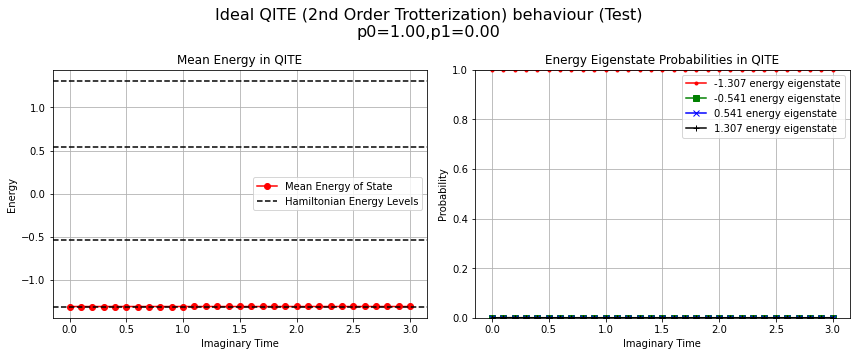

In [28]:
# For plotting lines
colors = ['r','g','b','k','m']
markers = ['.','s','x','+','*','h','H','D','o']

def multiple_runs(num_states, prob_incr):
    b = int(np.floor(1.0/prob_incr)) + 1
    for iter in range(b**(num_states-1)):
        init_sv = np.zeros(2**nbits,dtype=complex)
        probs = np.zeros(num_states)
        prob_string = ''
        digits = int_to_base(iter,b,num_states-1)
        for j in range(num_states-1):
            probs[j] = digits[j]*prob_incr
            prob_string += 'p{}={:0.2f},'.format(j, probs[j])
            init_sv += np.sqrt(probs[j]) * v[:,w_sort_i[j]]
        if np.sum(probs) > 1.0:
            continue
        else:
            probs[-1] = 1.0 - np.sum(probs)
            prob_string += 'p{}={:0.2f}'.format(num_states-1, probs[-1])
            init_sv += np.sqrt(probs[-1]) * v[:,w_sort_i[num_states-1]]
        
        init_sv = Statevector(init_sv)

        print('Iteration:',prob_string)
        log_file = log_path + prob_string
        fig_file = fig_path + prob_string

        E,times,states = ideal_qite_2nd_ord(db,delta,N,nbits,hm_list,init_sv,details=True,log=True,log_file=log_file)

        plt.clf()

        fig, axs = plt.subplots(1,2,figsize=(12,5))

        energy_state_probs = np.zeros([len(w), N+1], dtype=float)

        for i in range(N+1):
            for j in range(len(w)):
                energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], states[i].data) )**2

        fig.suptitle('Ideal QITE (2nd Order Trotterization) behaviour ({})\n{}'.format(h_name,prob_string), fontsize=16)
        plt.subplots_adjust(top=0.85)

        p1, = axs[0].plot(np.arange(0,N+1)*db, E, 'ro-')
        for ei in w:
            p2 = axs[0].axhline(y=ei, color='k', linestyle='--')
        axs[0].set_title('Mean Energy in QITE')
        axs[0].set_ylabel('Energy')
        axs[0].set_xlabel('Imaginary Time')
        axs[0].grid()
        axs[0].legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')

        for j in range(len(w)):
            axs[1].plot(np.arange(N+1)*db, energy_state_probs[w_sort_i[j]], '{}{}-'.format(colors[j%len(colors)], markers[j%len(markers)]), label='{:0.3f} energy eigenstate'.format(w[w_sort_i[j]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[0]], 'ro-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[0]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[1]], 'g.-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[1]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[2]], 'bs-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[2]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[3]], 'kP-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[3]]))

        axs[1].set_title('Energy Eigenstate Probabilities in QITE')
        axs[1].set_ylim([0,1])
        axs[1].set_ylabel('Probability')
        axs[1].set_xlabel('Imaginary Time')

        axs[1].grid()
        axs[1].legend(loc='best')

        fig.tight_layout()

        plt.savefig(fig_file+'.png')

multiple_runs(2,0.5)

Starting QITE Loop
i=1 Execution time: 0.10 seconds
i=2 Execution time: 0.26 seconds
i=3 Execution time: 0.68 seconds
i=4 Execution time: 0.64 seconds
i=5 Execution time: 0.89 seconds
i=6 Execution time: 1.21 seconds
i=7 Execution time: 1.45 seconds
i=8 Execution time: 1.47 seconds
i=9 Execution time: 1.68 seconds
i=10 Execution time: 1.73 seconds
i=11 Execution time: 2.25 seconds
i=12 Execution time: 2.48 seconds
i=13 Execution time: 2.68 seconds
i=14 Execution time: 2.91 seconds
i=15 Execution time: 2.78 seconds
i=16 Execution time: 3.26 seconds
i=17 Execution time: 3.22 seconds
i=18 Execution time: 3.81 seconds
i=19 Execution time: 4.05 seconds
i=20 Execution time: 3.88 seconds
i=21 Execution time: 4.35 seconds
i=22 Execution time: 4.59 seconds
i=23 Execution time: 4.84 seconds
i=24 Execution time: 5.38 seconds
i=25 Execution time: 5.54 seconds
i=26 Execution time: 5.73 seconds
i=27 Execution time: 6.17 seconds
i=28 Execution time: 5.68 seconds
i=29 Execution time: 6.25 seconds
i=30

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

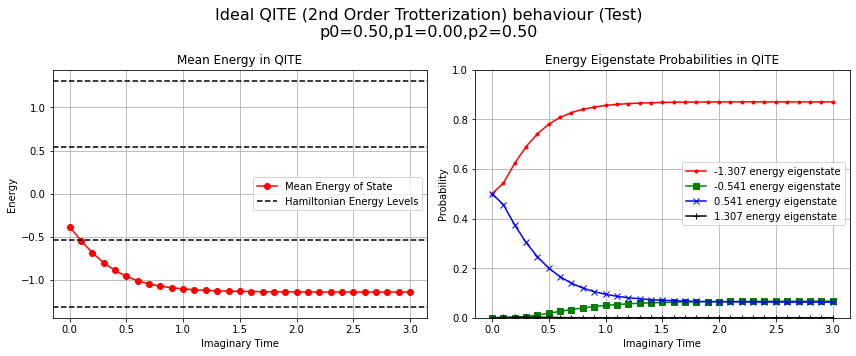

In [29]:
init_sv = Statevector( np.sqrt(0.5) * (v[:,w_sort_i[0]] + v[:,w_sort_i[2]]) )
prob_string = 'p0=0.50,p1=0.00,p2=0.50'
fig_file = fig_path+prob_string
log_file = log_path+prob_string
E,times,states = ideal_qite_2nd_ord(db,delta,N,nbits,hm_list,init_sv,details=True,log=True,log_file=log_file)

plt.clf()

fig, axs = plt.subplots(1,2,figsize=(12,5))

energy_state_probs = np.zeros([len(w), N+1], dtype=float)

for i in range(N+1):
    for j in range(len(w)):
        energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], states[i].data) )**2

fig.suptitle('Ideal QITE (2nd Order Trotterization) behaviour ({})\n{}'.format(h_name,prob_string), fontsize=16)
plt.subplots_adjust(top=0.85)

p1, = axs[0].plot(np.arange(0,N+1)*db, E, 'ro-')
for ei in w:
    p2 = axs[0].axhline(y=ei, color='k', linestyle='--')
axs[0].set_title('Mean Energy in QITE')
axs[0].set_ylabel('Energy')
axs[0].set_xlabel('Imaginary Time')
axs[0].grid()
axs[0].legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')

for j in range(len(w)):
    axs[1].plot(np.arange(N+1)*db, energy_state_probs[w_sort_i[j]], '{}{}-'.format(colors[j%len(colors)], markers[j%len(markers)]), label='{:0.3f} energy eigenstate'.format(w[w_sort_i[j]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[0]], 'ro-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[0]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[1]], 'g.-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[1]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[2]], 'bs-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[2]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[3]], 'kP-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[3]]))

axs[1].set_title('Energy Eigenstate Probabilities in QITE')
axs[1].set_ylim([0,1])
axs[1].set_ylabel('Probability')
axs[1].set_xlabel('Imaginary Time')

axs[1].grid()
axs[1].legend(loc='best')

fig.tight_layout()

plt.savefig(fig_file+'.png')
plt.show()

Starting QITE Loop
i=1 Execution time: 0.06 seconds
i=2 Execution time: 0.09 seconds
i=3 Execution time: 0.15 seconds
i=4 Execution time: 0.18 seconds
i=5 Execution time: 0.26 seconds
i=6 Execution time: 0.27 seconds
i=7 Execution time: 0.33 seconds
i=8 Execution time: 1.09 seconds
i=9 Execution time: 1.01 seconds
i=10 Execution time: 0.92 seconds
i=11 Execution time: 0.85 seconds
i=12 Execution time: 0.97 seconds
i=13 Execution time: 1.13 seconds
i=14 Execution time: 1.30 seconds
i=15 Execution time: 1.37 seconds
i=16 Execution time: 1.27 seconds
i=17 Execution time: 1.66 seconds
i=18 Execution time: 1.54 seconds
i=19 Execution time: 1.83 seconds
i=20 Execution time: 1.74 seconds
i=21 Execution time: 1.65 seconds
i=22 Execution time: 1.92 seconds
i=23 Execution time: 2.19 seconds
i=24 Execution time: 2.20 seconds
i=25 Execution time: 2.11 seconds
i=26 Execution time: 2.27 seconds
i=27 Execution time: 2.30 seconds
i=28 Execution time: 2.95 seconds
i=29 Execution time: 3.07 seconds
i=30

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

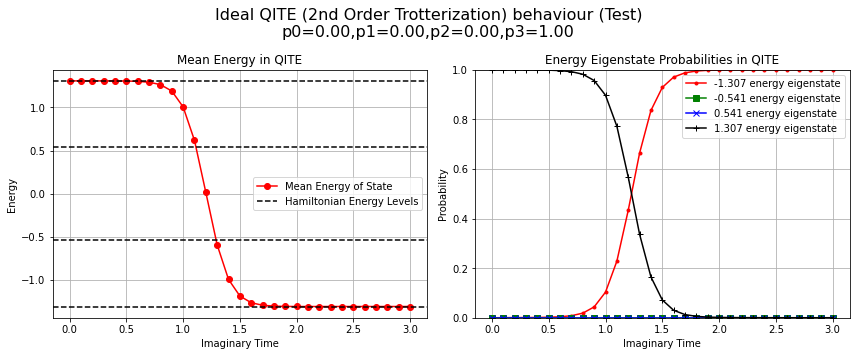

In [30]:
init_sv = Statevector( v[:,w_sort_i[3]] )
prob_string = 'p0=0.00,p1=0.00,p2=0.00,p3=1.00'
fig_file = fig_path+prob_string
log_file = log_path+prob_string
E,times,states = ideal_qite_2nd_ord(db,delta,N,nbits,hm_list,init_sv,details=True,log=True,log_file=log_file)

plt.clf()

fig, axs = plt.subplots(1,2,figsize=(12,5))

energy_state_probs = np.zeros([len(w), N+1], dtype=float)

for i in range(N+1):
    for j in range(len(w)):
        energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], states[i].data) )**2

fig.suptitle('Ideal QITE (2nd Order Trotterization) behaviour ({})\n{}'.format(h_name,prob_string), fontsize=16)
plt.subplots_adjust(top=0.85)

p1, = axs[0].plot(np.arange(0,N+1)*db, E, 'ro-')
for ei in w:
    p2 = axs[0].axhline(y=ei, color='k', linestyle='--')
axs[0].set_title('Mean Energy in QITE')
axs[0].set_ylabel('Energy')
axs[0].set_xlabel('Imaginary Time')
axs[0].grid()
axs[0].legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')

for j in range(len(w)):
    axs[1].plot(np.arange(N+1)*db, energy_state_probs[w_sort_i[j]], '{}{}-'.format(colors[j%len(colors)], markers[j%len(markers)]), label='{:0.3f} energy eigenstate'.format(w[w_sort_i[j]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[0]], 'ro-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[0]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[1]], 'g.-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[1]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[2]], 'bs-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[2]]))
# axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[3]], 'kP-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[3]]))

axs[1].set_title('Energy Eigenstate Probabilities in QITE')
axs[1].set_ylim([0,1])
axs[1].set_ylabel('Probability')
axs[1].set_xlabel('Imaginary Time')

axs[1].grid()
axs[1].legend(loc='best')

fig.tight_layout()

plt.savefig(fig_file+'.png')
plt.show()